> GNAR fiveNet,fivenodes lag 1

# import

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# torch
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

# scipy 
from scipy.interpolate import interp1d

# utils
import time
import pickle
from tqdm import tqdm

# rpy2
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import rpy2.robjects.numpy2ri as rpyn
import rpy2.robjects as robjects

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# my functions

In [3]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

In [4]:
def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [5]:
def plot(f,*args,t=None,h=2.5,**kwargs):
    T,N = f.shape
    if t == None: t = range(T)
    fig = plt.figure()
    ax = fig.subplots(N,1)
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
        ax[n].set_title('node='+str(n))
    fig.set_figheight(N*h)
    fig.tight_layout()
    plt.close()
    return fig

In [6]:
def plot_add(fig,f,*args,t=None,**kwargs):
    T = f.shape[0]
    N = f.shape[1] 
    if t == None: t = range(T)   
    ax = fig.get_axes()
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
    return fig

In [7]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

In [8]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [9]:
def trim(f):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape
    Psi = make_Psi(T)
    fbar = Psi.T @ f # apply dft 
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
    fhat = Psi @ fbar_threshed # inverse dft 
    return fhat

In [10]:
def update_from_freq_domain(signal, start, end, node):
    signal = np.array(signal)
    T,N = signal.shape 
    signal_trimed = trim(signal)
    signal[start:end,node] = signal_trimed[start:end,node]
    return signal

# data 정리 

`-` 데이터정리 

In [11]:
data = load_data('./data/fivenodes.pkl')

In [12]:
edges_tensor = torch.tensor(data['edges'])
fiveVTS = np.array(data['f'])
nonzero_indices = edges_tensor.nonzero()
fiveNet_edge = np.array(nonzero_indices).T
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

`-` train / test 

In [13]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

# BLock Missing Values

In [14]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.number = []
    def miss(self,start = 50,end = 150,node = 2):
        self.missing = self.df.copy()
        self.start = start
        self.end = end
        self.node = node
        self.missing[self.start:self.end,self.node] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        self.train_mean[self.start-1:self.end,self.node] = np.mean(self.df[:(self.start-1),self.node].tolist()+self.df[self.end:,self.node].tolist())
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

# STGCN 

- missing rate: 80% 
- 보간방법: linear

In [ ]:
stgcn_train1 = []
stgcn_test1 = []

_zero = Missing(fiveVTS_train)
_zero.miss(50,150,2)
_zero.second_linear()

missing_index = _zero.number
interpolated_signal = _zero.train_linear

X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

for i in range(100):
    net = RecurrentGCN(node_features=1, filters=4)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    net.train()
    for epoch in range(50):
        for time, (xt,yt) in enumerate(zip(X,y)):
            yt_hat = net(xt, edge_index, edge_attr)
            cost = torch.mean((yt_hat-yt)**2)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()

    yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
    yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()
    
    train_mse_total_stgcn = (((real_y-yhat).squeeze())**2).mean()
    test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()
    
    stgcn_train1.append(train_mse_total_stgcn.tolist())
    stgcn_test1.append(test_mse_total_stgcn.tolist())

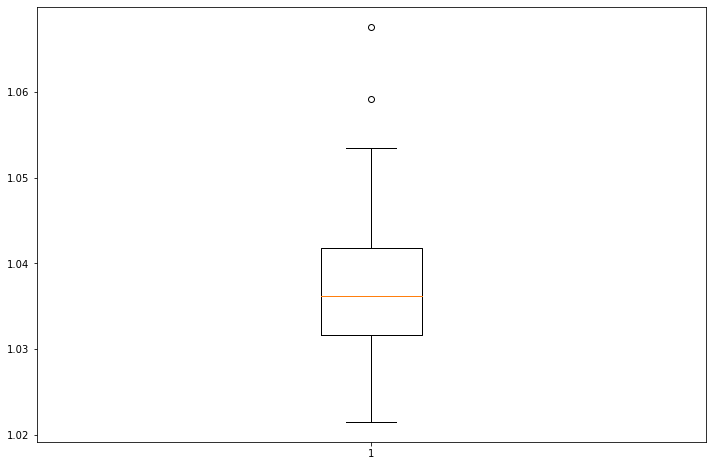

In [46]:
plt.figure(figsize=(12, 8))
plt.boxplot(stgcn_train1);

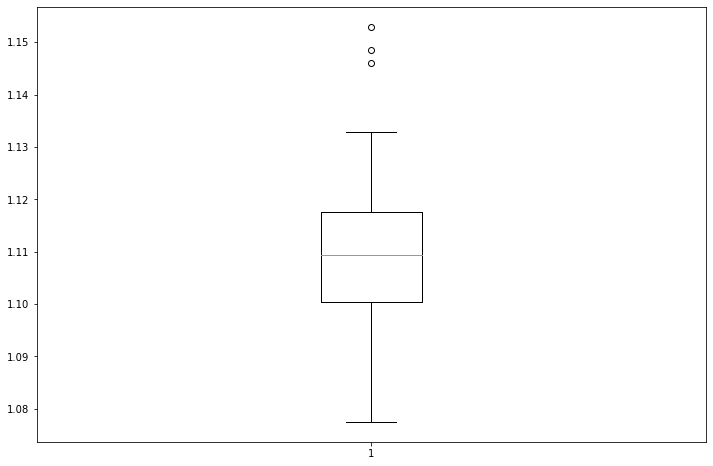

In [47]:
plt.figure(figsize=(12, 8))
plt.boxplot(stgcn_test1);

# Enhencement of STGCN 

- missing rate: 80% 
- 보간방법: linear

`-` 결측치생성 + 보간

In [ ]:
estgcn_train1 = []
estgcn_test1 = []

_zero = Missing(fiveVTS_train)
_zero.miss(50,150,2)
_zero.second_linear()

missing_index = _zero.number
interpolated_signal = _zero.train_linear

X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

for i in range(100):
    net = RecurrentGCN(node_features=1, filters=4)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    net.train()
    signal = interpolated_signal.copy()
    for epoch in range(50):
        signal = update_from_freq_domain(signal,50,150,2)
        X = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
        y = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[1:,:,:]
        for time, (xt,yt) in enumerate(zip(X,y)):        
            yt_hat = net(xt, edge_index, edge_attr)
            cost = torch.mean((yt_hat-yt)**2)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

    yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
    yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

    train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
    test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()
    
    estgcn_train1.append(train_mse_total_estgcn.tolist())
    estgcn_test1.append(test_mse_total_estgcn.tolist())

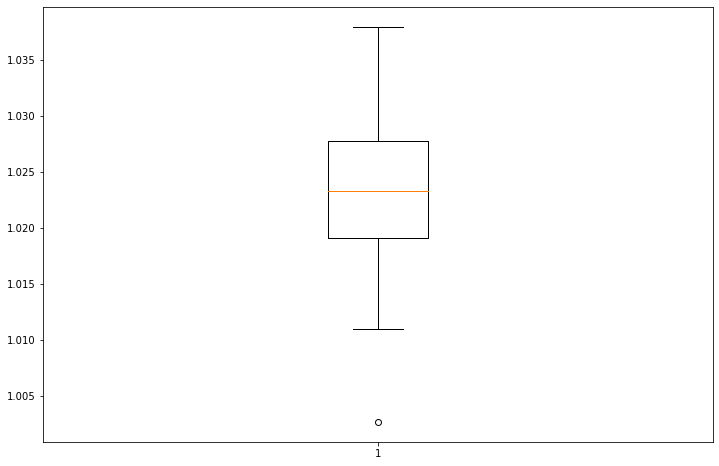

In [50]:
plt.figure(figsize=(12, 8))
plt.boxplot(estgcn_train1); 

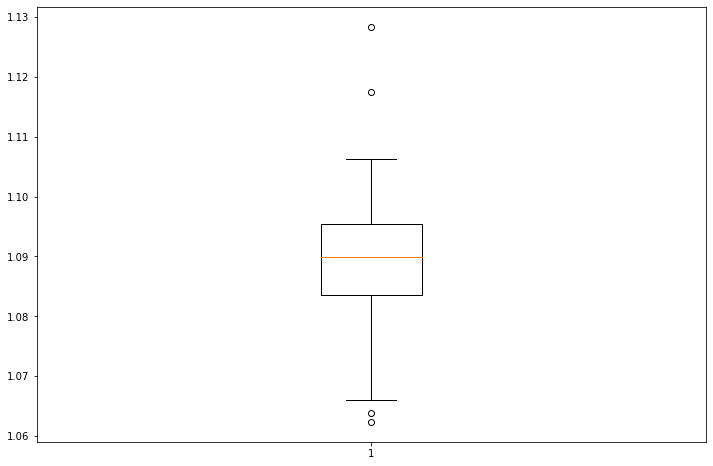

In [51]:
plt.figure(figsize=(12, 8))
plt.boxplot(estgcn_test1); 

# GNAR

In [62]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [63]:
%%R
library(GNAR)
library(igraph)
library(zoo)

In [64]:
GNAR = importr('GNAR') # import GNAR 
igraph = importr('igraph') # import igraph 

In [67]:
m = robjects.r.matrix(FloatVector([0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0]), nrow = 5, ncol = 5)
print(m)

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    1    1
[2,]    0    0    1    1    0
[3,]    0    1    0    1    0
[4,]    1    1    1    0    0
[5,]    1    0    0    0    0



In [68]:
gnar_train1 = []
gnar_test1 = []

_zero = Missing(fiveVTS_train)
_zero.miss(50,150,2)
_zero.second_linear()

missing_index = _zero.number
interpolated_signal = _zero.train_linear

X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-2),:,:]

yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

In [71]:
for i in range(100):
    
    answer = GNAR.GNARfit(vts=robjects.r.matrix(rpyn.numpy2rpy(np.array(X).squeeze()), nrow = 160, ncol = 5),net = GNAR.matrixtoGNAR(m), alphaOrder = 2, betaOrder = FloatVector([1, 1]))             
    predict = GNAR.predict_GNARfit(answer,n_ahead=40)

    
    train_mse_total_gnar = ((pd.DataFrame(GNAR.residuals_GNARfit(answer)).values.reshape(-1,5))**2).mean()
    test_mse_total_gnar = ((yy.squeeze() - pd.DataFrame(predict).values.reshape(-1,5)[:-1,:])**2).mean()
    
    gnar_train1.append(train_mse_total_gnar.tolist())
    gnar_test1.append(test_mse_total_gnar.tolist())

In [72]:
%R -o gnar_train1
%R -o gnar_test1

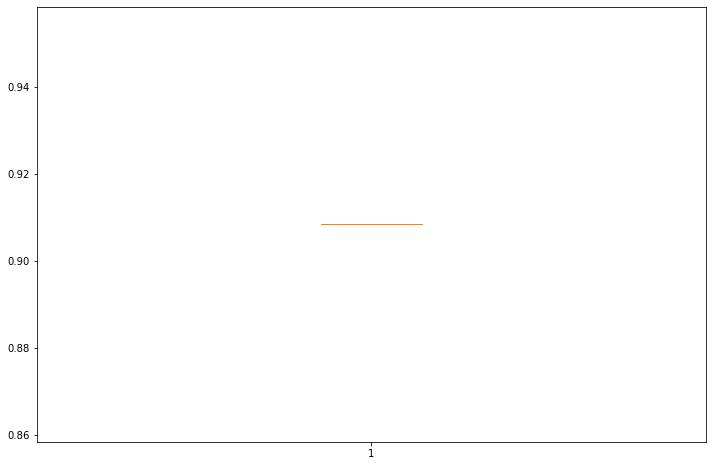

In [73]:
plt.figure(figsize=(12, 8))
plt.boxplot(gnar_train1);

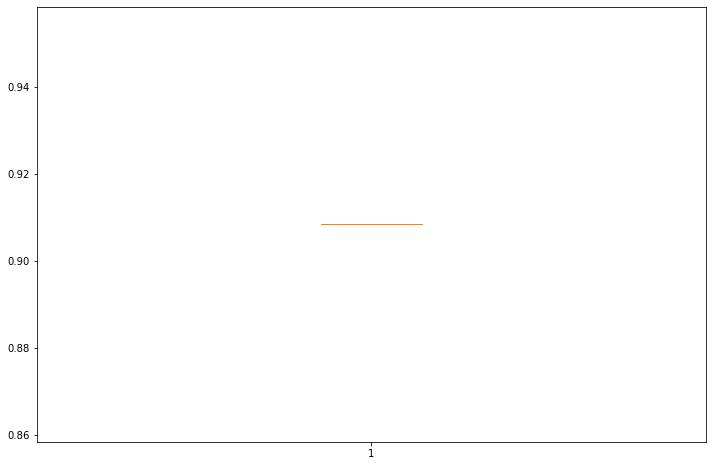

In [74]:
plt.figure(figsize=(12, 8))
plt.boxplot(gnar_test1);

# Visualization

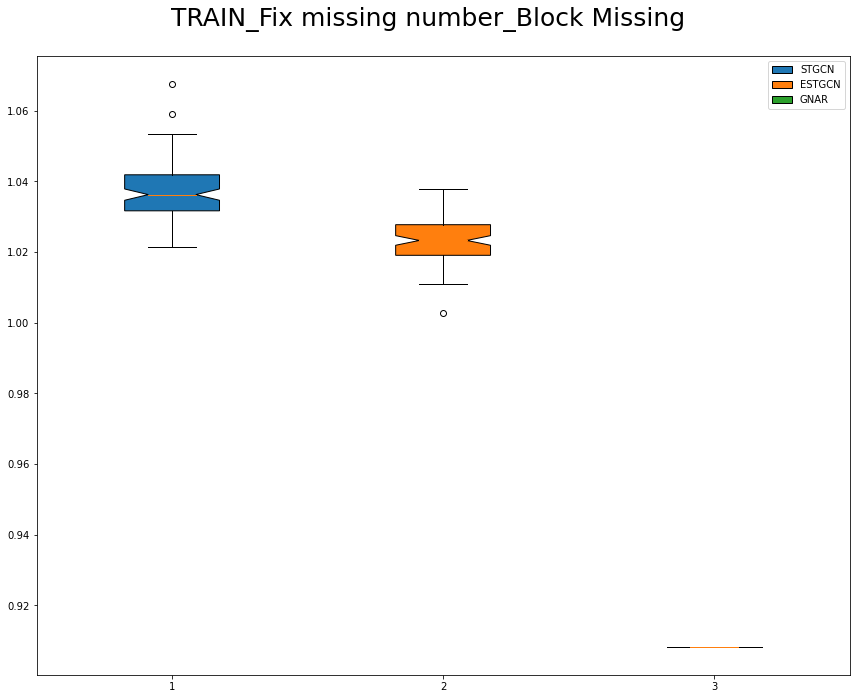

In [75]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)

bp1 = ax.boxplot(stgcn_train1, positions=[1], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C0"))
bp2 = ax.boxplot(estgcn_train1, positions=[2], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C1"))
bp3 = ax.boxplot(gnar_train1, positions=[3], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C2"))
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["STGCN", "ESTGCN", "GNAR"], loc='upper right')

plt.text(x=0.5, y=0.94, s="TRAIN_Fix missing number_Block Missing", fontsize=25, ha="center", transform=fig.transFigure)
fig.tight_layout()
plt.show()

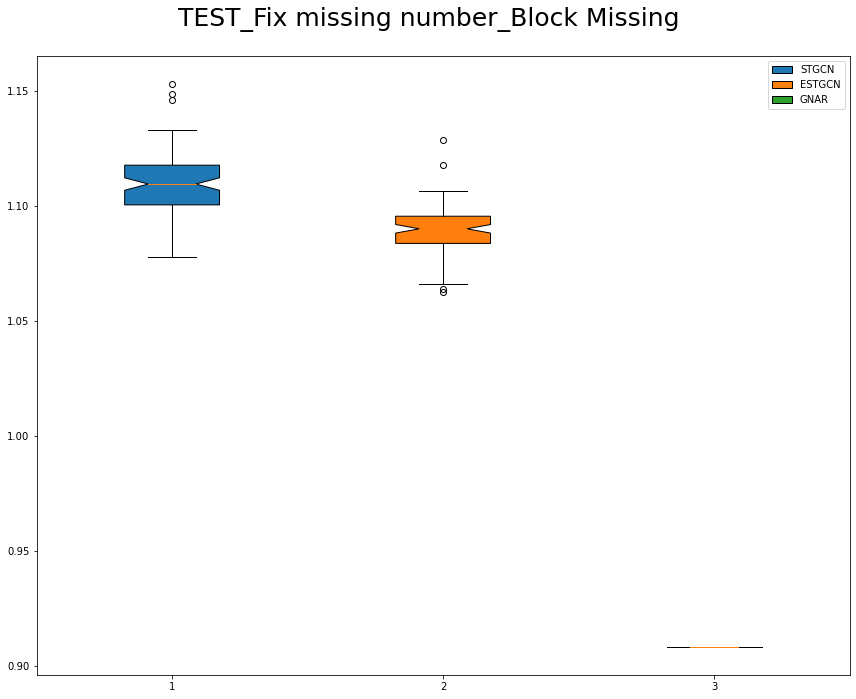

In [76]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(111)

bp1 = ax.boxplot(stgcn_test1, positions=[1], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C0"))
bp2 = ax.boxplot(estgcn_test1, positions=[2], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C1"))
bp3 = ax.boxplot(gnar_test1, positions=[3], notch=True, widths=0.35, patch_artist=True, boxprops=dict(facecolor="C2"))
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ["STGCN", "ESTGCN", "GNAR"], loc='upper right')

plt.text(x=0.5, y=0.94, s="TEST_Fix missing number_Block Missing", fontsize=25, ha="center", transform=fig.transFigure)
fig.tight_layout()
plt.show()